In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import pydicom
import glob, pylab
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")


import os
print(os.listdir("input"))



['stage_1_detailed_class_info.csv', 'stage_1_sample_submission.csv', 'stage_1_test_images', 'stage_1_train_images', 'stage_1_train_labels.csv']


In [2]:
# number of images in datasets
print(len(os.listdir("input/stage_1_test_images")), 'imgs in a test set')
print(len(os.listdir("input/stage_1_train_images")), 'imgs in a train set')

1000 imgs in a test set
25684 imgs in a train set


In [3]:
class_info = pd.read_csv('input/stage_1_detailed_class_info.csv', index_col='patientId')
train_labeles = pd.read_csv('input/stage_1_train_labels.csv', index_col='patientId')

In [4]:
class_info.head()

,class
patientId,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [9]:
train_labeles.head(5)

,x,y,width,height,Target
patientId,,,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [10]:
#some patients have more than one bounding box
train_labeles[train_labeles.index.values == '00436515-870c-4b36-a041-de91049b9ab4']

,x,y,width,height,Target
patientId,,,,,
00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


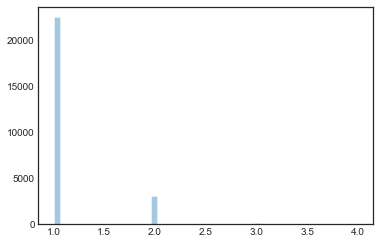

In [11]:
#a vast majority of images though have 1 bounding box, rarely 2, and almost never 3 or 4
num_of_boxes_per_patient = train_labeles.index.value_counts().values
sns.distplot(num_of_boxes_per_patient, kde=False)

# Different types of classes

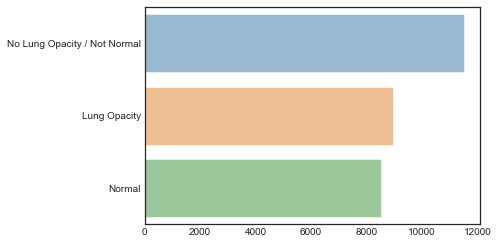

In [12]:
classes = class_info['class'].value_counts()
sns.barplot(y=classes.index, x=classes.values, alpha=0.5)

# Distribution of bounding boxes

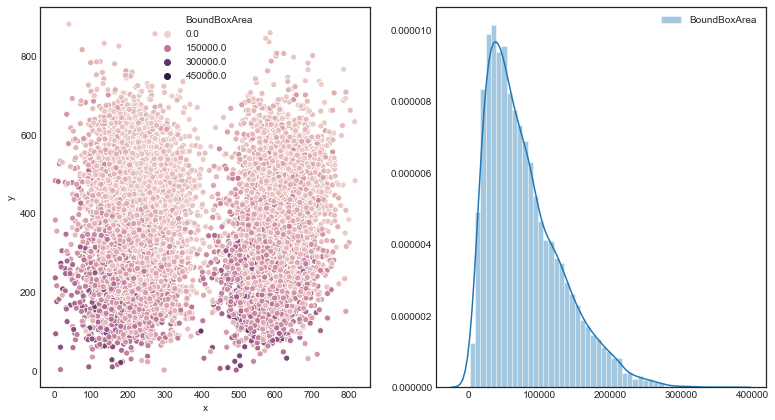

In [13]:
train_labeles['BoundBoxArea'] = train_labeles.width*train_labeles.height
train_labeles.BoundBoxArea.fillna(0, inplace=True)
boxes = train_labeles[train_labeles.BoundBoxArea > 0]

fig, axs = plt.subplots(1, 2, figsize=(13, 7))
sns.scatterplot(x='x', y='y', hue='BoundBoxArea', data=boxes, ax=axs[0])
sns.distplot(boxes.BoundBoxArea.values, ax=axs[1], label='BoundBoxArea')
plt.legend()
plt.show()

In [15]:
boxes.head()

,x,y,width,height,Target,BoundBoxArea
patientId,,,,,,
00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,80727.0
00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,115968.0
00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,16640.0
00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,22194.0
00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,12690.0


# Some images with and without bounding boxes

In [29]:
#https://www.kaggle.com/peterchang77/exploratory-data-analysis

def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'input/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [30]:
df = pd.read_csv('input/stage_1_train_labels.csv')
parsed = parse_data(df)

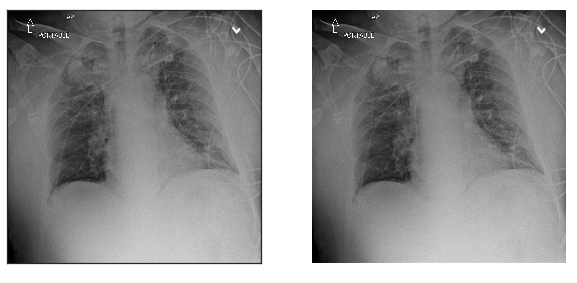

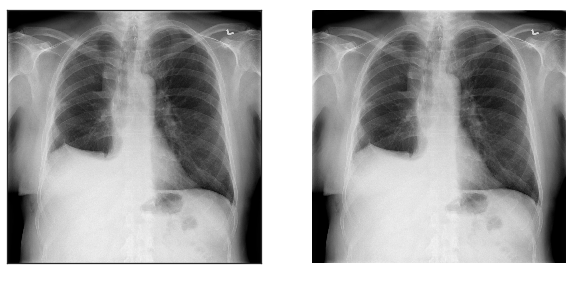

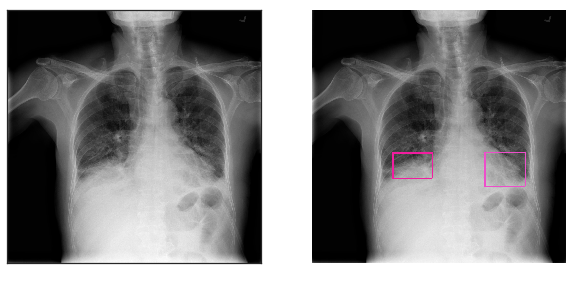

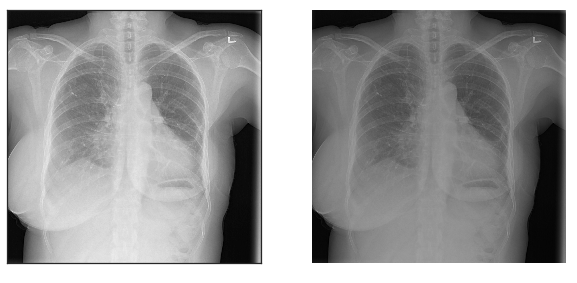

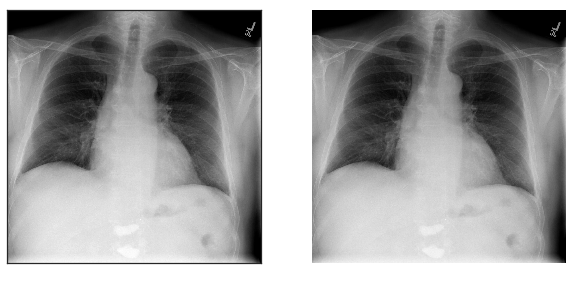

In [31]:
for i in range(5,10):
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    patientId = train_labeles.index.unique()[i]
    draw(parsed[patientId])
    dcm_file = 'input/stage_1_train_images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    axes[0].imshow(im, cmap=pylab.cm.gist_gray)
    axes[0].set_yticklabels([])
    axes[0].set_xticklabels([])
